Partie 1
#Chargement des données 

In [56]:
import pandas as pd
import re

def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'

# Patterns for extracting train and test data
train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'

# Extracting train and test data
rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(len(train_df))
print(len(test_df)) 


104
104


Partie 2

##Apprentissage sur train

In [57]:
import numpy as np

def perceptron_batch(training_features, training_labels, epochs=22000, learning_rate=0.001):

    # Initialisation des poids
    weights = np.zeros(training_features.shape[1] + 1)
    
    # Entraînement
    for _ in range(epochs):
        # Initialisation du vecteur de mise à jour pour cette époque
        update = np.zeros(training_features.shape[1] + 1)
        
        for inputs, label in zip(training_features, training_labels):
            # Calcul de la prédiction
            activation = np.dot(inputs, weights[1:]) + weights[0]
            if activation >= 0:
                prediction = 1
            else:
                prediction = -1
            
            # Accumulation de la mise à jour basée sur l'erreur
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        
        # Mise à jour des poids à la fin de l'époque
        weights += update
    
    return weights

# Préparation des données
# Supposons que train_df est déjà défini et mélangé
# Convertir les étiquettes 'R' et 'M' en valeurs numériques -1 et 1
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparation des caractéristiques et des étiquettes
train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

# Entraînement du perceptron
weights = perceptron_batch(train_features, train_labels)

Calcul de Ea et de Eg

In [58]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1

# Fonction pour calculer la précision
def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

# Convertir les étiquettes de l'ensemble de test en valeurs numériques -1 et 1
# test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparer les caractéristiques et les étiquettes de l'ensemble de test
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

print (test_labels)
predictions = [predict_perceptron(x, weights) for x in test_features]
print (predictions)
# Calculer la précision sur l'ensemble d'entraînement et de test
training_accuracy = calculate_accuracy(train_features, train_labels, weights)
testing_accuracy = calculate_accuracy(test_features, test_labels, weights)

# Calculer les erreurs d'apprentissage (Ea) et de généralisation (Eg)
Ea = 1 - training_accuracy
Eg = 1 - testing_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")

print("Les poids du perceptron",weights)

[-1  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1
  1 -1  1 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1
  1 -1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1 -1
  1 -1  1  1  1  1 -1 -1]
[-1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1]
Erreur d'apprentissage (Ea) : 0.0
Erreur de généralisation (Eg) : 0.1923076923076923
Les poids du perceptron [-0.98       0.842751   2.1072314  0.3838012  1.1038062  0.7259872
  1.4434456 -0.6594728 -1.5828186  0.0899288  1.0787674  0.38768
  0.1341432  0.0255996  0.042866   0.5863472 -1.958266  -0.5572258
  2.0306202 -

Fonction de stabilité

In [59]:
def calculate_stability(features, labels, weights):
    norm_w = np.linalg.norm(weights[1:])  # Calcul de la norme du vecteur de poids (sans le biais)
    stabilities = []
    for x, y in zip(features, labels):
        # Calcul de la marge fonctionnelle pour chaque exemple
        gamma = y * (np.dot(weights[1:], x) + weights[0]) / norm_w
        stabilities.append(gamma)
    return stabilities

# Calcul des stabilités pour l'ensemble de test
test_stabilities = calculate_stability(test_features, test_labels, weights)

# Afficher les stabilités des exemples de test
print(test_stabilities)




[0.03666161187971247, 0.1672186978506818, -0.05038148598081701, -0.009165359455143154, 0.05965049762299453, 0.007729754812903349, -0.002168965686701239, 0.021634245022494183, 0.045805859551022954, 0.006841335479758372, 0.028455246265524613, -0.023492685040114206, 0.06810040308189756, 0.06265733368468047, 0.013523552468365395, 0.03803587343384066, -0.01623132799915774, 0.008042335191417324, 0.1284684886715685, -0.03217561629121448, 0.07141577406176314, 0.13282763219600344, 0.03142980891714381, 0.046213156787434644, 0.04629023850265363, 0.08627464181863251, 0.08248702066141066, 0.050756492785767306, -0.05801110738738641, 0.20261388007172682, 0.10841419895432172, 0.1304026125731042, 0.007441359997908242, 0.00014255995467257583, 0.09616320527108105, 0.04067017616195606, -0.014154321773546322, 0.053318402661172055, 0.17605211668319337, -0.10987461833133909, 0.025140511904148698, 0.030945614124010142, 0.06654454302776867, 0.09763893175006033, 0.057372142993354094, 0.11231781199791745, 0.1642

Graph

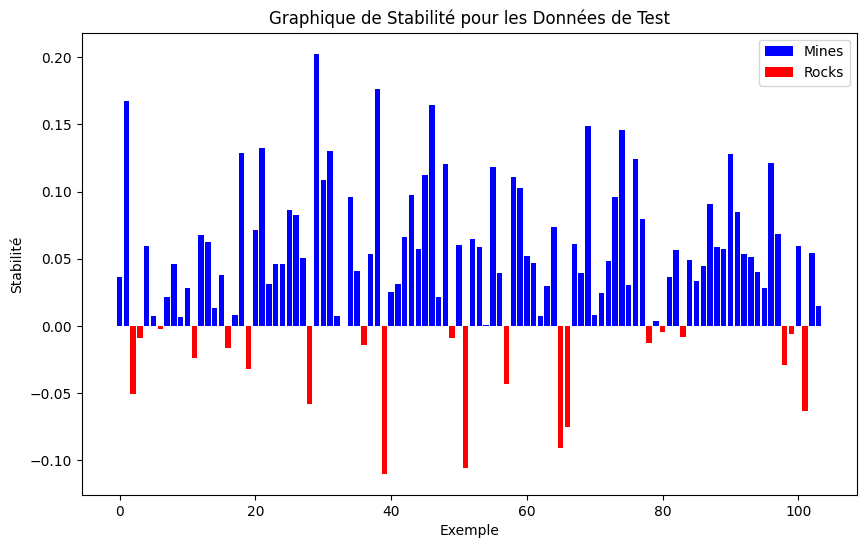

In [61]:
import matplotlib.pyplot as plt

# Définir les étiquettes pour les mines et les roches
# Ici, nous simulons les étiquettes. Dans votre cas, utilisez les étiquettes réelles de vos données
labels = ['Bien classé' if val > 0 else 'Mal classé' for val in test_stabilities]

# Créer le graphique de stabilité
plt.figure(figsize=(10, 6))

# Barres pour les exemples classés comme mines
plt.bar(range(len(test_stabilities)), [val if val > 0 else 0 for val in test_stabilities], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(test_stabilities)), [val if val < 0 else 0 for val in test_stabilities], 
        color='red', label='Mal classé')

# Ajouter des légendes, des étiquettes et un titre
plt.legend()
plt.xlabel('Exemple')
plt.ylabel('Stabilité')
plt.title('Graphique de Stabilité pour les Données de Test')

# Afficher le graphique
plt.show()
